# Predicting Heart Disease  

## Classification Model Stepwise Analysis <a id='top'></a> 

1. [Research Question](#1)<br/>
2. [DataFrames](#2) <br/>
3. [Exporatory Data Analysis](#3)<br/>
4. [Baselining](#4)<br/>
5. [Validation and Testing](#5)<br/>
6. [Model Iterations](#6) <br/>
7. [Model Selection ](#7)<br/>



In [18]:
import pandas as pd
import numpy as np
import imblearn.over_sampling
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from sklearn.compose import make_column_transformer
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression ,LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.svm import SVC ,SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier




## 1. Research Question<a id='1'></a> 

How might we predict which patients are at high risk of heart disease?
* **Impact Hypothesis:** Reduce the number of patients who develop heart disease (arterial plaque or heart attack).
* **Data source:** [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease), n=319,795
* **Error metric:** Recall

[Data Dictionary](https://www.cdc.gov/brfss/annual_data/2020/pdf/codebook20_llcp-v2-508.pdf)<br/>

_Target_
- `y_heart_disease`: Y/N | coronary heart disease (CHD) or myocardial infarction (MI)

_Health Behaviors
- `behavior_activity`: Num (0-30) | # days did physical activity/ exercise other than regular job
- `behavior_alcohol`: Y/N | heavy drinker, defined as men: 14+/wk, women: 7+/wk (includes beer, wine, malt beverage, liquor)
- `behavior_sleep`: Num (0-24) | # hours of sleep in a 24-hour period, on average
- `behavior_tobacco`: Y/N | smoked at least 100 cigarettes in your life

_Demographics_
- `demg_age`: 18-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+
- `demg_gender`: male/female
- `demg_race`: White, Black, Asian, American Indian/Alaskan Native, Hispanic, Other race

_Health Measures_
- `health_bmi`: Num | Body Mass Index (BMI)
- `health_physical`: Num (0-30) | # days physical health  not good, includes physical illness and injury
- `health_mental`: Num (0-30 ) | # days mental health not good, includes stress, depression, and problems with emotions
- `health_general`: Excellent, Very Good, Fair, Poor | Would you say that in general your health is...
- `health_mobility`: Y/N | serious difficulty walking or climbing stairs

_Chronic Disease_
- `disease_asthma`: Y/N
- `disease_diabetes`: Y/N/Y pregnancy/N borderline
- `disease_kidney`: Y/N | kidney disease, excludes kidney stones, bladder infection or incontinence
- `disease_skin`: Y/N | skin cancer
- `disease_stroke`: Y/N

## 2. [DataFrames](https://github.com/slp22/classification-project/blob/main/classification-heart-disease_mvp.ipynb)<a id='2'></a>  


1. `heart_disease_df` 
2. `heart_disease_df_map`
3. `heart_disease_df_dmy`

In [32]:
# Load cleaned and transformed dataframes from mvp 
heart_disease_df = pd.read_csv('heart_disease_df.csv') # Cleaned df
heart_disease_df_map = pd.read_csv('heart_disease_df_map.csv') # Mapped variables df
heart_disease_df_dmy = pd.read_csv('heart_disease_df_dmy.csv') # Dummy varibales df


In [53]:
heart_disease_df.head(3)

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,Yes,No,5.0,Yes,55-59,Female,White,Yes,Yes,No,Yes,No,16.60,Very good,30.0,No,3.0,No
1,Yes,No,7.0,No,80 or older,Female,White,No,No,No,No,Yes,20.34,Very good,0.0,No,0.0,No
2,Yes,No,8.0,Yes,65-69,Male,White,Yes,Yes,No,No,No,26.58,Fair,30.0,No,20.0,No


In [54]:
heart_disease_df_map.head(3)

,behavior_activity,behavior_alcohol,behavior_sleep,behavior_tobacco,demg_age,demg_gender,demg_race,disease_asthma,disease_diabetes,disease_kidney,disease_skin,disease_stroke,health_bmi,health_general,health_mental,health_mobility,health_physical,y_heart_disease
0,1,0,5.0,1,55,1,6,1,1,0,1,0,16.60,4,30.0,0,3.0,0
1,1,0,7.0,0,80,1,6,0,0,0,0,1,20.34,4,0.0,0,0.0,0
2,1,0,8.0,1,65,2,6,1,1,0,0,0,26.58,2,30.0,0,20.0,0


In [55]:
heart_disease_df_dmy.head(3)

,behavior_sleep,health_bmi,health_mental,health_physical,behavior_activity_Yes,behavior_alcohol_Yes,behavior_tobacco_Yes,demg_age_25-29,demg_age_30-34,demg_age_35-39,...,disease_diabetes_Yes_pregnancy,disease_kidney_Yes,disease_skin_Yes,disease_stroke_Yes,health_general_Fair,health_general_Good,health_general_Poor,health_general_Very good,health_mobility_Yes,y_heart_disease_Yes
0,5.0,16.60,30.0,3.0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,7.0,20.34,0.0,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,8.0,26.58,30.0,20.0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## 3. Exporatory Data Analysis<a id='3'></a> 

**Look at, summarize, and clean the data.** 
- Examine at least some rows in micro detail, 
    - checking that the data is correct and 
    - appears as you expected (e.g., number of customers should not be negative!). 
- Also study the macro level by aggregating the data and looking at 
    - summary information and statistics (what is the data type, 
    - how many entries and missing values are there, 
    - what are some descriptive statistics like mean for numerical columns, etc.) 
- Significant preprocessing/data preparation may be called for in cases of messy/problematic data.

In [56]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   behavior_activity  319795 non-null  object 
 1   behavior_alcohol   319795 non-null  object 
 2   behavior_sleep     319795 non-null  float64
 3   behavior_tobacco   319795 non-null  object 
 4   demg_age           319795 non-null  object 
 5   demg_gender        319795 non-null  object 
 6   demg_race          319795 non-null  object 
 7   disease_asthma     319795 non-null  object 
 8   disease_diabetes   319795 non-null  object 
 9   disease_kidney     319795 non-null  object 
 10  disease_skin       319795 non-null  object 
 11  disease_stroke     319795 non-null  object 
 12  health_bmi         319795 non-null  float64
 13  health_general     319795 non-null  object 
 14  health_mental      319795 non-null  float64
 15  health_mobility    319795 non-null  object 
 16  he

In [47]:
# Descriptive stats on numeric features
heart_disease_df.describe()[1:][['health_bmi',
                                 'health_physical',
                                 'health_mental', 
                                 'behavior_sleep'
                                ]].T.style.background_gradient(cmap='Blues')


,mean,std,min,25%,50%,75%,max
health_bmi,28.325399,6.356100,12.020000,24.030000,27.340000,31.420000,94.850000
health_physical,3.371710,7.950850,0.000000,0.000000,0.000000,2.000000,30.000000
health_mental,3.898366,7.955235,0.000000,0.000000,0.000000,3.000000,30.000000
behavior_sleep,7.097075,1.436007,1.000000,6.000000,7.000000,8.000000,24.000000


[back to top](#top)

**Scope out classification viability:** 
- Look at key statistics and visualizations related to classification - 
    - correlation matrix, 
    - target distribution (how imbalanced are the classes you're predicting?), 
    - target vs. feature plots (e.g. seaborn pairplot with the target value passed as a hue, see logistic regression notebook for a good example). 
- Get some initial expectations for model performance and identify features that intuitively, visually, and based on their per-class distributions (e.g. box plots by target class) are likely to work well.

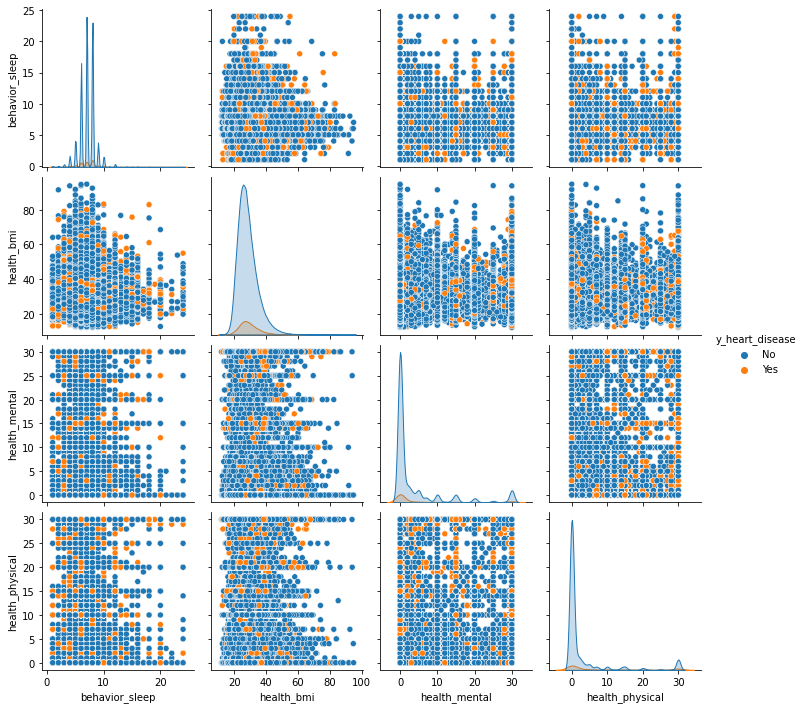

In [63]:
# Correlation matrix 
sns.pairplot(heart_disease_df, hue='y_heart_disease');


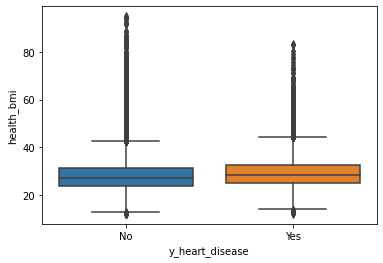

In [72]:
sns.boxplot(x='y_heart_disease', y='health_bmi', data=heart_disease_df);

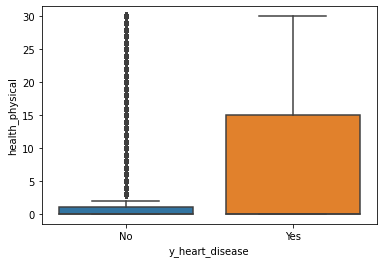

In [73]:
sns.boxplot(x='y_heart_disease', y='health_physical', data=heart_disease_df);

In [62]:
# Target distribution

print('\nData in heart_disease_df:')
print(heart_disease_df['y_heart_disease'].value_counts())
print('Yes/No Ratio:', round(27373/292422, 4) * 100, '%')


Data in heart_disease_df:
No     292422
Yes     27373
Name: y_heart_disease, dtype: int64
Yes/No Ratio: 9.36 %


In [ ]:
# Target vs. feature plots 
# sns pairplot with the target value passed as a hue, see logistic regression notebook 



In [ ]:
- Get some initial expectations for model performance and identify features that intuitively, visually, and based on their per-class distributions (e.g. box plots by target class) are likely to work well.

**Determine the most relevant classification metric(s):** 
- Given the model's use case and the distribution of the target, what metrics are most relevant for this problem? 
- It's critical to establish this before modeling so that you can properly decide how well a model is actually working. 
- Is the class distribution balanced and accuracy is a meaningful metric? Do you need to have good recall and precision for the positive class (use F1)? 
- Is recall more important than precision (use F_beta with beta > 1, care about recall beta times more than precision)? 
- Is it a probability ranking problem (use ROC AUC)? Think carefully about cost-benefit analysis from the use case perspective to decide on the right metric(s).

In [22]:
#### AgeCategory: apply a function to calculate the mean age and make it a continuous feature

encode_AgeCategory = {'55-59':57, '80 or older':80, '65-69':67,
                      '75-79':77,'40-44':42,'70-74':72,'60-64':62,
                      '50-54':52,'45-49':47,'18-24':21,'35-39':37,
                      '30-34':32,'25-29':27}
df['AgeCategory'] = df['AgeCategory'].apply(lambda x: encode_AgeCategory[x])
df['AgeCategory'] = df['AgeCategory'].astype('float')


[back to top](#top)

## 4. Baselining<a id='4'></a> 

- Build a simple baseline model such as 
    - logistic regression, 
    - KNN, or 
    - naive Bayes, 
    using a small handful of features (you might get lucky and be able to explain your targets with very few features). 
- Start with features that are most likely to be predictive based on your domain knowledge and EDA (step 1) and/or are simple to handle (e.g. numeric without null values). 
- Calculate the model evaluation metrics you've determined are relevant to get a baseline score and feel for how well the model can perform. 
- Ideally, calculate the baseline score on a hold out set as in part 3, not the training data.

[back to top](#top)

## 5. Validation and Testing<a id='5'></a>

- Set up a data splitting structure for validating and testing your model. 
- Cross-validation will often be preferable to simple, single-set validation due to its robustness. 
- There may also be cases where a specialized validation setup is called for, such as in time series problems. 
- Using your chosen validation scheme, you can perform iterative feature selection/expansion/engineering and model complexity adjustments in order to complete the next 2 steps. 
- You will use the test data only once your model is finalized in order to compute a final estimate of generalization performance.



[back to top](#top)

## 6. Model Iterations <a id='6'></a> 

- Starting from the baseline and in an iterative, validated loop ask: 
    - Do you need more complexity or less (underfitting vs. overfitting)? 
    - Do you need a fancier model (nonlinear, additional feature engineering / transformations)? 
    - If you need more complexity, try tree-based models such as random forest or gradient boosted trees. 
    - Are you overfitting and need to make your model more conservative by removing features or using regularization? - Hopefully you can quickly acquire an understanding of which direction you need to go in from your baseline and early modeling results, then make more fine-tuned changes as you go.


- The impact of model choices should be consistently measured against the same validation data as in part 3, using your relevant classification performance metrics such as F1 or ROC AUC. 


#### k-Nearst Neighbors

[back to top](#top)

#### Logistic Regression 

[back to top](#top)

#### Random Forests

[back to top](#top)

#### Gradient Boosted Trees

[back to top](#top)

#### Ensembling

[back to top](#top)

#### Naive Bayes

[back to top](#top)

### Error metric: Recall

[back to top](#top)

### Class Imblance Handling 

- If your target class distribution is (highly) imbalanced, make sure to try imbalance handling strategies such as 
    - resampling, 
    - class_weight adjustments, and 
    - decision threshold tuning that dovetail with the metrics you’re most interested in. 
- These methods are part of the modeling process, whether they happen before, during, or after training.

In [31]:
print('\nData in df:')
print(df['HeartDisease'].value_counts())


Data in df:
No     292422
Yes     27373
Name: HeartDisease, dtype: int64


[back to top](#top)

### Feature Engineering 

- The [feature engineering](https://app.thisismetis.com/courses/162/pages/home-feature-engineering-for-classification) lesson provides a model for how you might track your progress while iteratively expanding your model. 

In [ ]:
class_0 = val_df[val_df['HeartDisease'] == 0]
class_1 = val_df[val_df['HeartDisease'] == 1]

class_1 = class_1.sample(len(class_0),replace=True)
val_df = pd.concat([class_0, class_1], axis=0)
print('Data in Test:')
print(val_df['HeartDisease'].value_counts())

[back to top](#top)

## 7. Model Selection<a id='7'></a> 

**Finalize and test:** 
- When satisfied with the results of your tuning in _Model Iterations_, establish your final model choices:
        - features, 
        - preprocessing, 
        - imbalance handling strategy, and 
        - hyperparameters
    - retrain this model on all training + validation data. 
- Make predictions on the test data and score these predictions, reporting this score as your estimate of the model's generalization performance.

**Interpret:** 
- Extract and study your final model coefficients or feature importances. Are there any interesting or unexpected takeaways? 
- How do the model coefficients/importances align with your intuition and domain knowledge about the problem? 
- Be careful about complicating factors in interpretation such as differing feature scales and multicollinearity.



In [25]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7,5))

ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['No HeartDisease','HeartDisease'])
ax.yaxis.set_ticklabels(['No HeartDisease','HeartDisease'])

plt.show()

NameError: name 'y_val' is not defined

[back to top](#top)